# Assignment: Linear Models
## Do three questions.
### `! git clone https://github.com/ds4e/linearModels`

**Q1.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?
2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)
3. Can linear regression be used for classification? Explain why, or why not.
4. What are signs that your linear model is over-fitting?
5. Clearly explain multi-colinearity using the two-stage least squares technique.
6. How can you incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$ into your analysis?
7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?

1. A model is linear when its parameters are only multiplied by features and added together.

2.  When you include an intercept and dummy variables for all categories, you have perfect multicollinearity . You must omit one category, which becomes the reference/base category represented by the intercept. Then each dummy coefficient represents the difference from that base category.

3. No, as linear regression predicts continuous values where classification needs discrete ones.

4. If your model performs extremely well on the training set, but fails to generalize to new inputs that it has not seen before.

5. This occurs when independent variables in a regression model are highly correlated, making it difficult to isolate their individual effects. Two-Stage least squares technique addresses this by first regressing the problematic variable on variables that are not correlated with the problem one to obtain predicted values, then using these predictions in the second-stage regression.

6. You could use things such as polynomial terms, logarithmic functions, or feature engineering.

7. The intercept is the expected value of $y$ when all independent variables are 0. The slope coefficient is the expected change in $y$ for a one unit increase in $x$. The dummy variable coefficient is the difference in expected $y$ between the dummy category and the base category.

**Q3.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Load data
cars = pd.read_csv("./data/cars_hw.csv")

In [10]:
# Remove zero or negative prices
cars = cars[cars['Price'] > 0]
# Log transform for better scaling
cars['Mileage_Run'] = np.log1p(cars['Mileage_Run'])

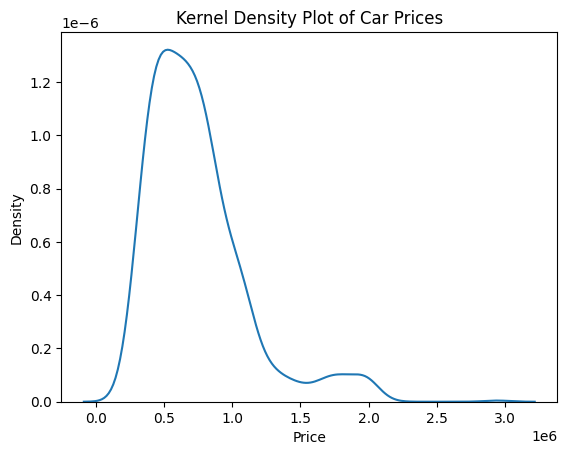

In [14]:
# KDP of price
sns.kdeplot(cars['Price'])
plt.title("Kernel Density Plot of Car Prices")
plt.xlabel("Price")
plt.show()

In [17]:
# Grouped summary stats by make
summary_by_make = cars.groupby('Make')['Price'].describe().sort_values(by='mean', ascending=False)
summary_by_make

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
MG Motors,35.0,1.869457e+06,1.216611e+05,1589000.0,1786500.0,1848000.0,1978000.0,2019000.0
Kia,8.0,1.614750e+06,1.190567e+05,1369000.0,1579000.0,1628500.0,1705750.0,1741000.0
Jeep,4.0,1.499500e+06,1.525134e+05,1290000.0,1447500.0,1529500.0,1581500.0,1649000.0
Skoda,5.0,1.136000e+06,1.070175e+06,436000.0,466000.0,538000.0,1299000.0,2941000.0
Mahindra,18.0,1.100167e+06,1.755493e+05,796000.0,1037000.0,1094500.0,1157000.0,1465000.0
Tata,23.0,1.055217e+06,5.578305e+05,188000.0,779500.0,869000.0,1552000.0,2100000.0
Nissan,4.0,8.842500e+05,2.895599e+05,475000.0,782500.0,978000.0,1079750.0,1106000.0
Toyota,50.0,8.003400e+05,2.466900e+05,368000.0,526250.0,894000.0,1023000.0,1092000.0
Honda,73.0,7.989726e+05,2.665091e+05,316000.0,581000.0,785000.0,915000.0,1537000.0


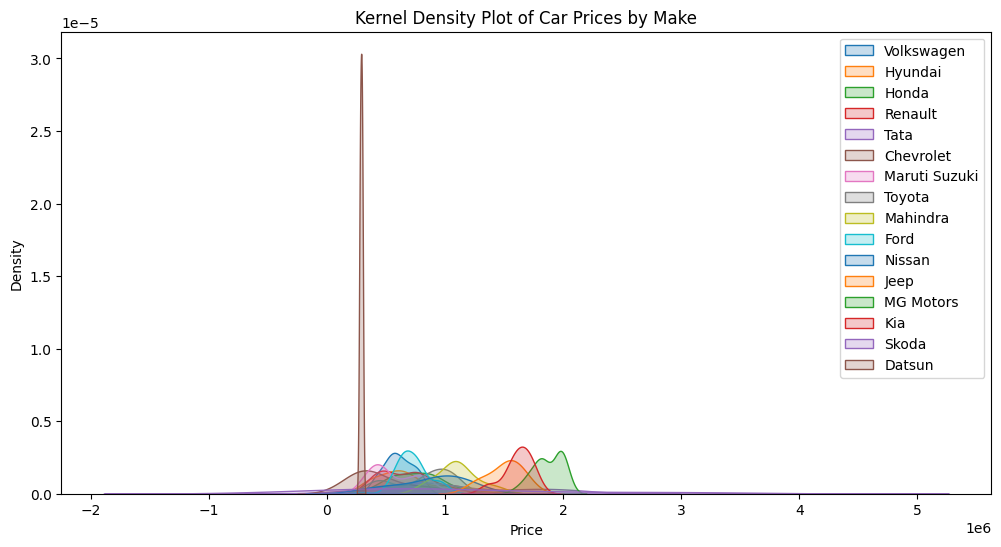

In [19]:
# KDP by Make
plt.figure(figsize=(12, 6))
for make in cars['Make'].unique():
    sns.kdeplot(cars[cars['Make'] == make]['Price'], label=make, fill=True)
plt.legend()
plt.title("Kernel Density Plot of Car Prices by Make")
plt.xlabel("Price")
plt.show()

In [ ]:
# MG motors is the most expensive brand, but in general, the prices are right skewed.

In [21]:
# Train test split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(cars, test_size=0.2, random_state=42)

In [22]:
# Model 1: Regression on Numeric Variables Only
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

numeric_features = ['Seating_Capacity', 'Mileage_Run', 'Make_Year']
X_train_num = train[numeric_features]
X_test_num = test[numeric_features]
y_train = train['Price']
y_test = test['Price']

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

model1 = LinearRegression()
model1.fit(X_train_num_scaled, y_train)
y_pred_train = model1.predict(X_train_num_scaled)
y_pred_test = model1.predict(X_test_num_scaled)

r2_train_1 = r2_score(y_train, y_pred_train)
r2_test_1 = r2_score(y_test, y_pred_test)
rmse_train_1 = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test_1 = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Model 1 - Numeric Variables Only: R^2 on Test Set = {r2_test_1}, RMSE = {rmse_test_1}")

Model 1 - Numeric Variables Only: R^2 on Test Set = 0.31497105250241675, RMSE = 280302.9177839414


In [23]:
# Model 2: One-Hot Encoded Categorical Variables Only
categorical_features = ['Body_Type', 'Make', 'Fuel_Type', 'Transmission_Type']
X_train_cat = pd.get_dummies(train[categorical_features], drop_first=True)
X_test_cat = pd.get_dummies(test[categorical_features], drop_first=True)
common_cols = X_train_cat.columns.intersection(X_test_cat.columns)
X_train_cat = X_train_cat[common_cols]
X_test_cat = X_test_cat[common_cols]

model2 = LinearRegression()
model2.fit(X_train_cat, y_train)
y_pred_test_2 = model2.predict(X_test_cat)

r2_test_2 = r2_score(y_test, y_pred_test_2)
rmse_test_2 = np.sqrt(mean_squared_error(y_test, y_pred_test_2))

print(f"Model 2 - Categorical Variables Only: R^2 on Test Set = {r2_test_2}, RMSE = {rmse_test_2}")

Model 2 - Categorical Variables Only: R^2 on Test Set = 0.6551755320037889, RMSE = 198871.33721095338


In [24]:
# Model 3: Combining Numeric and Categorical Variables
X_train_combined = np.hstack([X_train_num_scaled, X_train_cat])
X_test_combined = np.hstack([X_test_num_scaled, X_test_cat])

model3 = LinearRegression()
model3.fit(X_train_combined, y_train)
y_pred_test_3 = model3.predict(X_test_combined)

r2_test_3 = r2_score(y_test, y_pred_test_3)
rmse_test_3 = np.sqrt(mean_squared_error(y_test, y_pred_test_3))

print(f"Model 3 - Combined: R^2 on Test Set = {r2_test_3}, RMSE = {rmse_test_3}")

Model 3 - Combined: R^2 on Test Set = 0.7856685211176476, RMSE = 156789.19734359832


In [ ]:
# Model 3 performs best, with R² = 0.786 and the lowest RMSE of 156,789, significantly outperforming Models 1 and 2. Categorical variables are more predictive than numeric ones, but combining both improves accuracy. The joint model reduces RMSE by 123,514 over Model 1 and 42,082 over Model 2, making it the most effective choice.

In [29]:
# Polynomial Feature Expansion
from sklearn.preprocessing import PolynomialFeatures
for degree in range(1, 10):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_num_scaled)
    X_test_poly = poly.transform(X_test_num_scaled)

    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)
    y_pred_test_poly = model_poly.predict(X_test_poly)

    r2_test_poly = r2_score(y_test, y_pred_test_poly)
    rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_pred_test_poly))

    print(f"Polynomial Model (degree {degree}): R^2 on Test Set = {r2_test_poly}, RMSE = {rmse_test_poly}")

Polynomial Model (degree 1): R^2 on Test Set = 0.31497105250241664, RMSE = 280302.91778394143
Polynomial Model (degree 2): R^2 on Test Set = 0.3323705727418761, RMSE = 276720.2185377355
Polynomial Model (degree 3): R^2 on Test Set = 0.29609288182510063, RMSE = 284138.99171770667
Polynomial Model (degree 4): R^2 on Test Set = -0.0036471316451909264, RMSE = 339284.23498517973
Polynomial Model (degree 5): R^2 on Test Set = -1.7099613063577248, RMSE = 557512.6185302079
Polynomial Model (degree 6): R^2 on Test Set = -852.652998117058, RMSE = 9894955.410687478
Polynomial Model (degree 7): R^2 on Test Set = -3738.057408595935, RMSE = 20708766.112285763
Polynomial Model (degree 8): R^2 on Test Set = -3918703.7256703908, RMSE = 670416086.9343597
Polynomial Model (degree 9): R^2 on Test Set = -583302072.5531313, RMSE = 8179371175.049453


In [ ]:
# As the polynomial degree increases, R² initially improves slightly (degree 2) but then declines sharply, becoming negative at degree 4, while RMSE continuously worsens. The best model is degree 2 (R² = 0.332, RMSE = 276,720), but it still underperforms compared to the combined model from part 4 (R² = 0.786, RMSE = 156,789), showing that polynomial expansion does not significantly improve prediction.

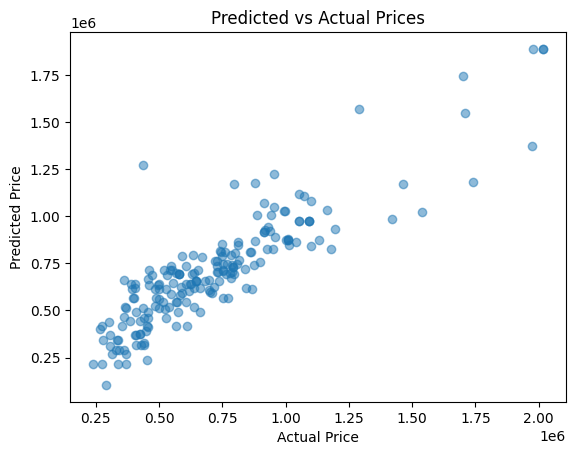

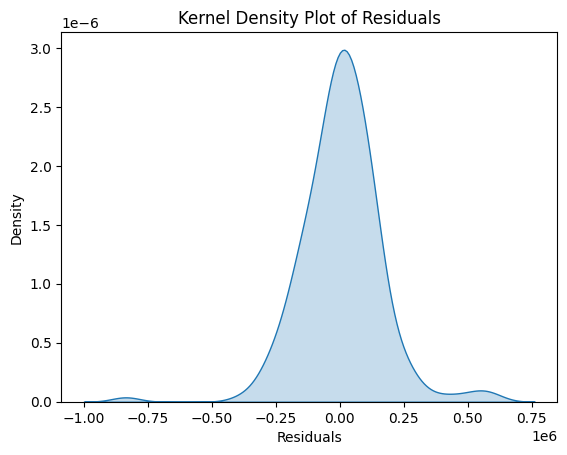

In [31]:
# Plot Predicted vs Actual Prices
plt.scatter(y_test, y_pred_test_3, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

# Kernel Density Plot of Residuals
residuals = y_test - y_pred_test_3
sns.kdeplot(residuals, fill=True)
plt.title("Kernel Density Plot of Residuals")
plt.xlabel("Residuals")
plt.show()

In [ ]:
# The predicted values and actual values roughly line up along the diagonal, indicating a good fit.
# The residuals are roughly bell-shaped around zero, suggesting that the model's errors are normally distributed.
# Some strengths of the model are that it is simple and easy to interpret, and it performs well on the test set.
# Some weaknesses of the model are that it may not capture all the nuances of the data, and it may be overfitting to the training data.

**Q7.** In class, we showed that for the single linear regression model,
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

1. When will $b^*$ be large or small, depending on the relationship between $X$ and $Y$ and the variance of $X$?
2. Suppose you have measurement error in $X$ which artificially inflates its variance (e.g. bad data cleaning). We'll model this as saying the "real" value of $X$ for observation $i$ is $z_i$, but we observe $x_i = z_i + n_i$, where $n_i$ is the added noise. Does this affect the intercept of the regression? What happens to the $b^*$ coefficient relative to a noise-less model? How will affect your ability to predict? (This phenomenon is called **attenuation**.) 
3. Suppose the noise $n_i$ is independent of $z_i$ and $y_i$, so that (approximately)
$$
\dfrac{1}{N} \sum_{i=1}^N (y_i - \bar{y})(n_i - \bar{n}) =0, \quad \dfrac{1}{N} \sum_{i=1}^N (z_i - \bar{z})(n_i - \bar{n}) =0.
$$
and that the mean of the bias is zero, so that
$$
\dfrac{1}{N} \sum_{i=1}^N n_i = 0.
$$
In this case, the noise $n_i$ is zero on average and independent of the values of $x_i$ and $y_i$: It's just measurement error or lazy data cleaning.
Explain the intuition of your result. 

4. How does attenuation factor into the cost-benefit analysis of gathering higher quality data or cleaning it more carefully?

1. $b*$ will be large when there is a strong correlation between $X$ and $Y$ and when $X$ has low variance. On the other hand, $b*$ will be small if the correlation is weak or if $X$ has high variance.

2. Measurement error in $X$ inflates its variance, which biases $b*$ downward due to attenuation. The intercept remains mostly unaffected, but the predictive power weakens because the slope underestimates the true effect of $X$ on $Y$.

3. Since $n_i$ is independent and has a mean of zero, it increased the denominator of $b*$ without affecting the numerator, leading to a dampened slope. This means that adding noise to $X$ makes it harder to detect the true relationship between $X$ and $Y$, weakening the model's predictive accuracy.

4. Attenuation highlights the trade-off between data quality and effort, as poor data cleaning or noisy data collection reduces the estimated effect of key predictors, leading to underpowered models. Investing in higher-quality data improves estimates and predictions, but the cost must be weighed against the expected improvement in decision-making.